In [13]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import geopy.distance
import pandas as pd
import numpy as np


order = pd.read_csv('orderstatus.csv', sep = ';', encoding = 'utf-8').iloc[:,:-7].dropna()

sellers = pd.read_csv('sellers_temp.csv', sep = ';', encoding = 'utf-8')
sellers.rename(columns = {'seller_city':'city'}, inplace = True)

customer = pd.read_csv('customer_dataset.csv', sep = ';', encoding = 'utf-8').iloc[:,[0,1]]
customer.rename(columns = {'customer_city':'city'}, inplace = True)

geo = pd.read_csv('geo_dataset.csv', sep = ';', encoding = 'utf-8').iloc[:,[0,1,2]]

order = pd.merge(order, customer, on = 'customer_unique_id', how = 'left')

order = pd.merge(order, geo, on = 'city', how = 'left')

order.rename(columns = {'city':'customer_city',
                        'city_lat':'customer_city_lat',
                        'cit_long':'customer_city_long'}, inplace = True)

order = pd.merge(order, sellers, on = 'seller_id', how = 'left')

order = pd.merge(order, geo, on = 'city', how = 'left')

order.rename(columns = {'city':'seller_city',
                        'city_lat':'seller_city_lat',
                        'cit_long':'seller_city_long'}, inplace = True)

def distancer(row):
    coords_1 = (row['customer_city_lat'], row['customer_city_long'])
    coords_2 = (row['seller_city_lat'], row['seller_city_long'])
    return geopy.distance.geodesic(coords_1, coords_2).km

order['distance'] = order.apply(distancer, axis=1)

order['consegnato_date'] = pd.to_datetime(order['consegnato_date'], dayfirst = True)
order['purchase_date'] = pd.to_datetime(order['purchase_date'], dayfirst = True)
order['approved_date'] = pd.to_datetime(order['approved_date'], dayfirst = True)
order['corriere_date'] = pd.to_datetime(order['corriere_date'], dayfirst = True)
order['stimato_date'] = pd.to_datetime(order['stimato_date'], dayfirst = True)

/var/folders/9g/430d659n24x98lk_m6dccs1r0000gp/T/ipykernel_13009/1714243109.py:14: DtypeWarning:

Columns (2,3,7,8,9,10,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.

/var/folders/9g/430d659n24x98lk_m6dccs1r0000gp/T/ipykernel_13009/1714243109.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
order['appr_purc'] = (order['approved_date'] - order['purchase_date']).dt.days
order['corr_appr'] = (order['corriere_date'] - order['approved_date']).dt.days
order['cons_corr'] = (order['consegnato_date'] - order['corriere_date']).dt.days
order['delta_time'] = (order['consegnato_date'] - order['purchase_date']).dt.days

order = order.sort_values(by = 'purchase_date')

In [15]:
order_time = order.iloc[:100,[-4,-3,-2]].reset_index(drop = True)

fig = px.bar(order_time,
             x = order_time.index,
             y = [c for c in order_time.columns],
             title = 'Distribution of deltatime per order_id')
fig.show()

In [16]:
fig = px.pie(order_time.sum(axis = 0),
             values=0,
             names=order_time.sum(axis = 0).index,
             title = 'Global distribution of delta time')
fig.show()

Text(0.5, 1.0, 'Correlation among variables')

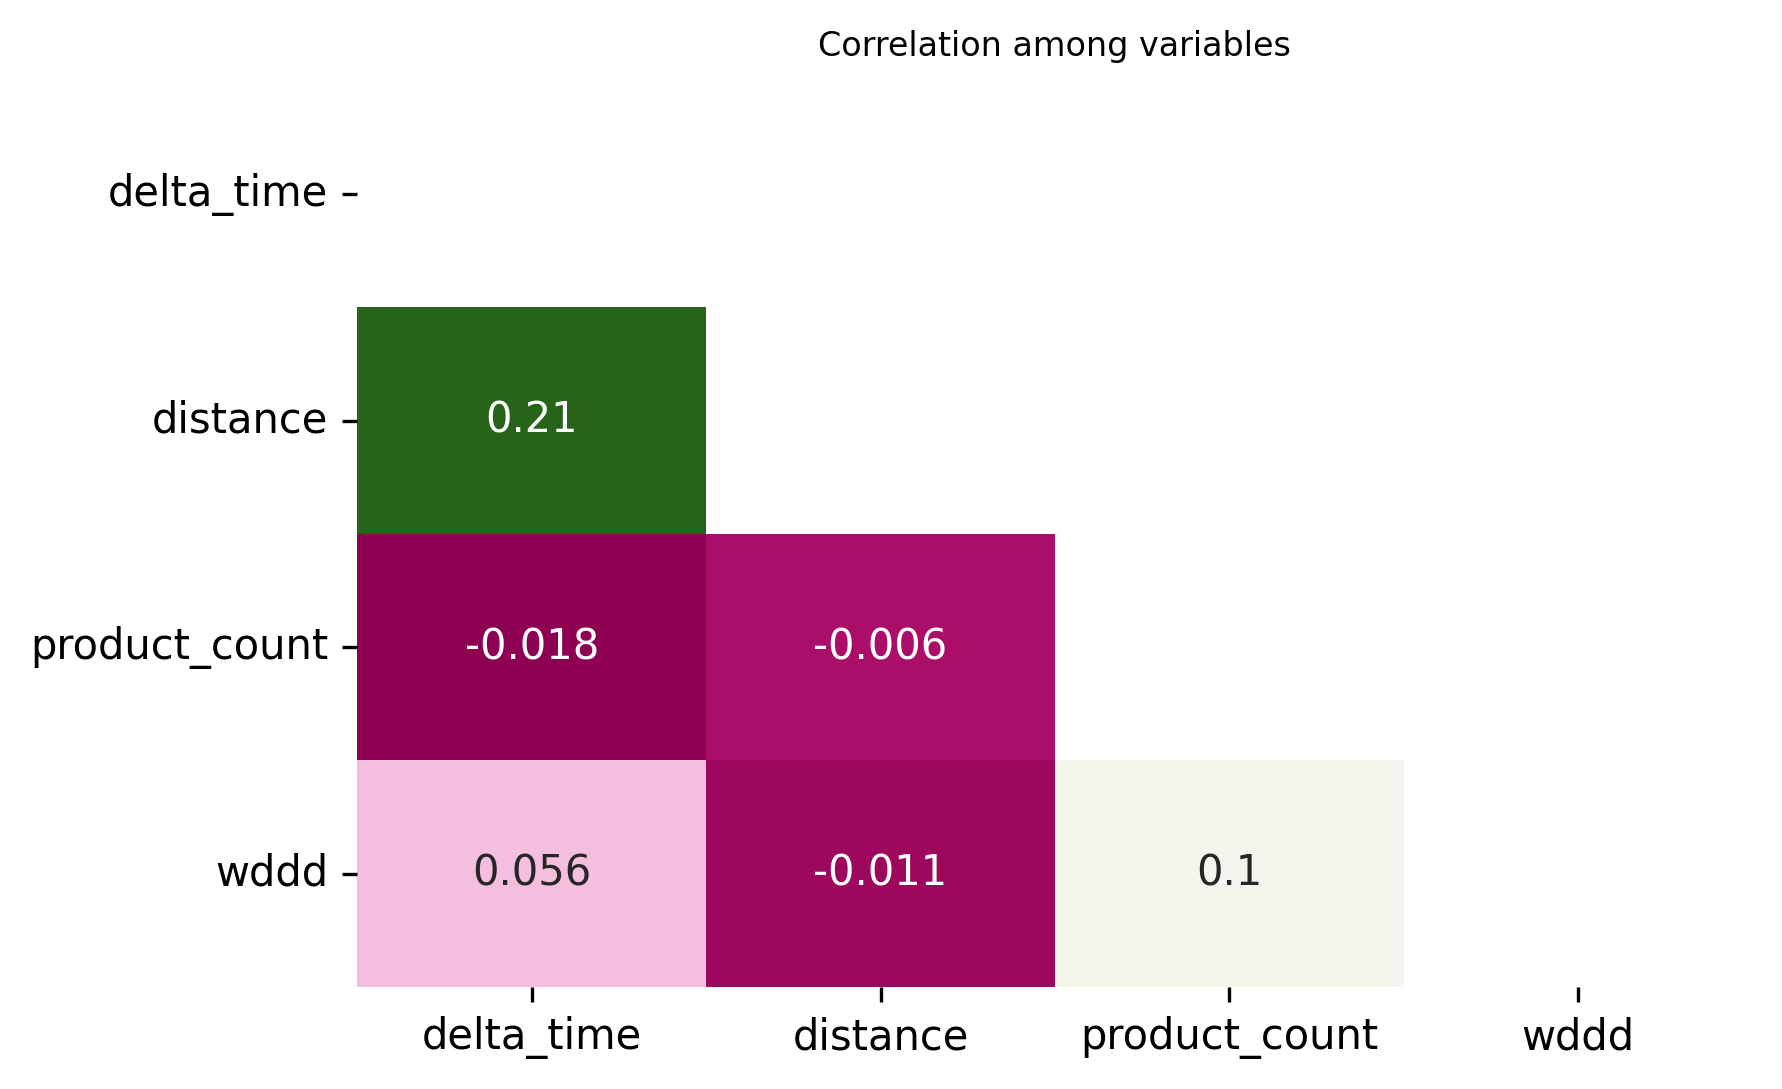

In [17]:
order_correlation = order.iloc[:,[-1,-5,-12,-13]]

corr = order_correlation.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(dpi = 300)
sns.heatmap(corr,
            cmap = 'PiYG',
            cbar = False,
            annot = True,
            mask = mask)

plt.title('Correlation among variables', fontsize = 8)